## Surprise Housing Assignment

'train.csv' file contains detail requried for the Assignment

Problem Statement:
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price.<br>
In Assignment we are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [154]:
#import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [172]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV


### Analysing the data

In [2]:
#load csv file
housing_data = pd.read_csv('train.csv')

In [3]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

###### There are so many columns thats why visualising data with pandas is bit difficult. Hence now will make use of missingno library.
###### Display all columns whose values is null with missingno

<Axes: >

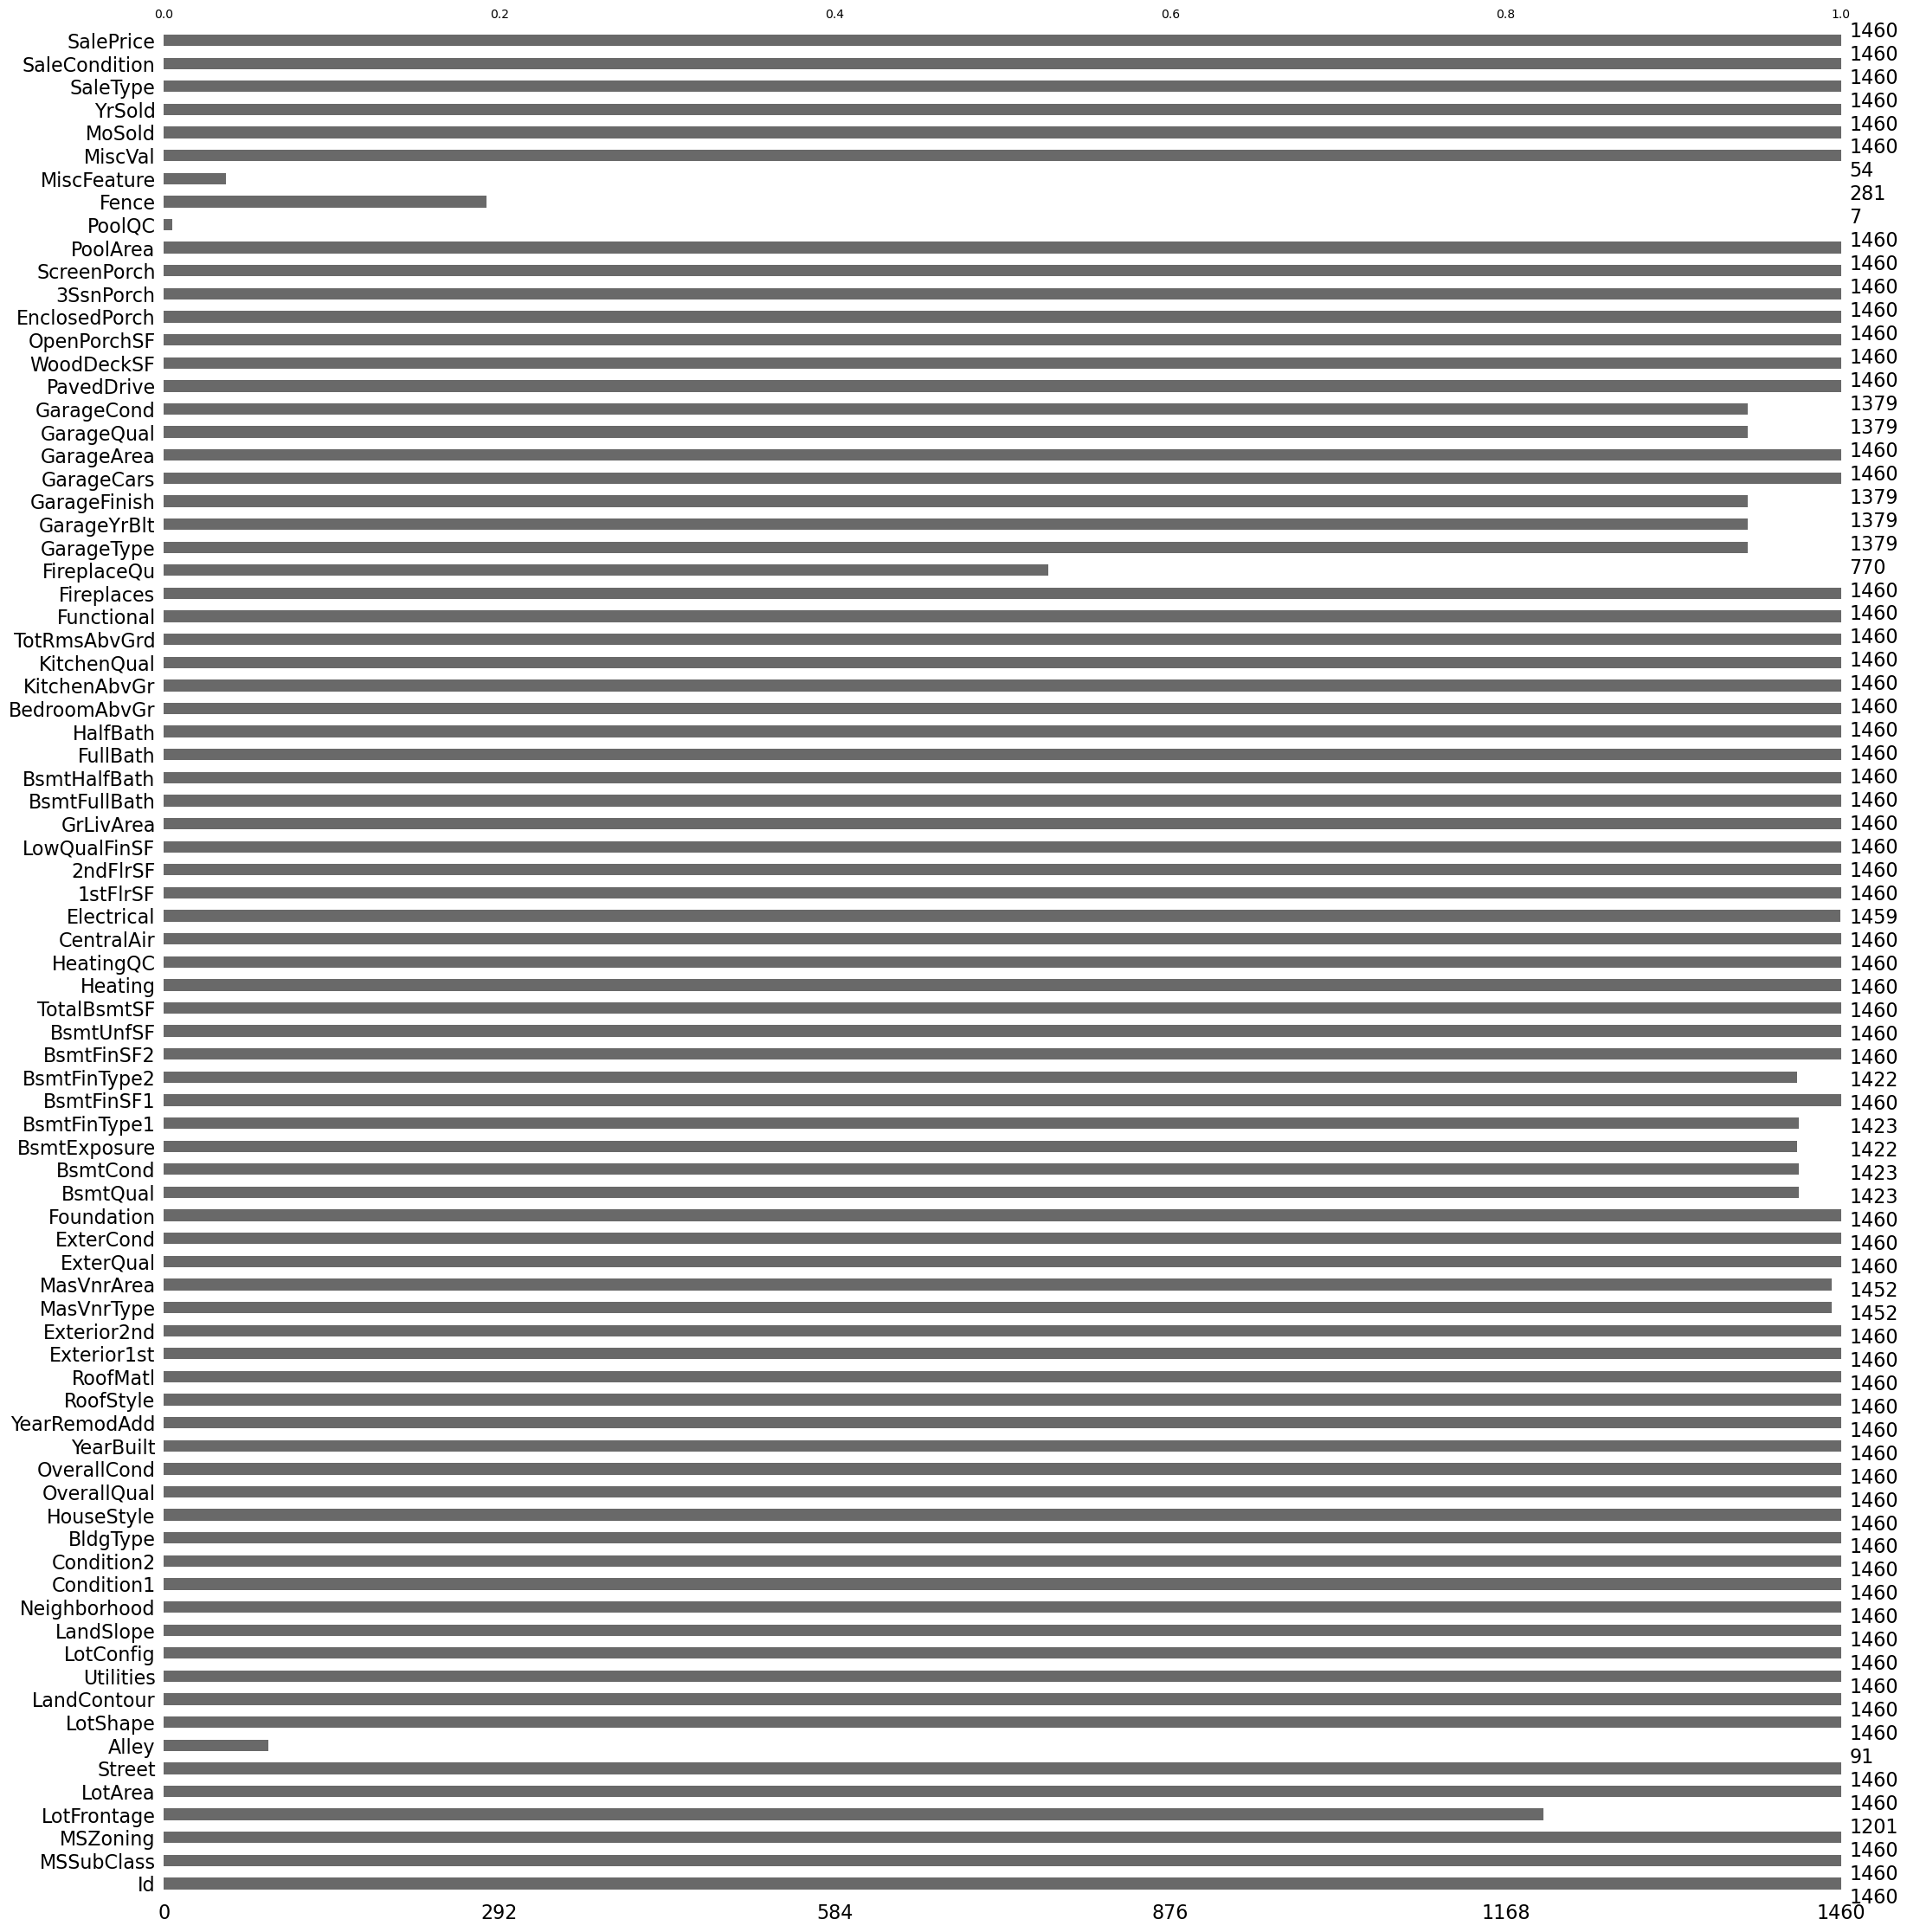

In [4]:
msno.bar(housing_data)

#### Let's look at all the columns whose null/NAN is more than 80%
Now from the above graph we know those columns are MiscFeature, Fence, PoolQC, FireplaceQU and Alley

In [5]:
housing_data.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [6]:
housing_data.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [7]:
housing_data.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [8]:
housing_data.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [9]:
housing_data.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

<Axes: >

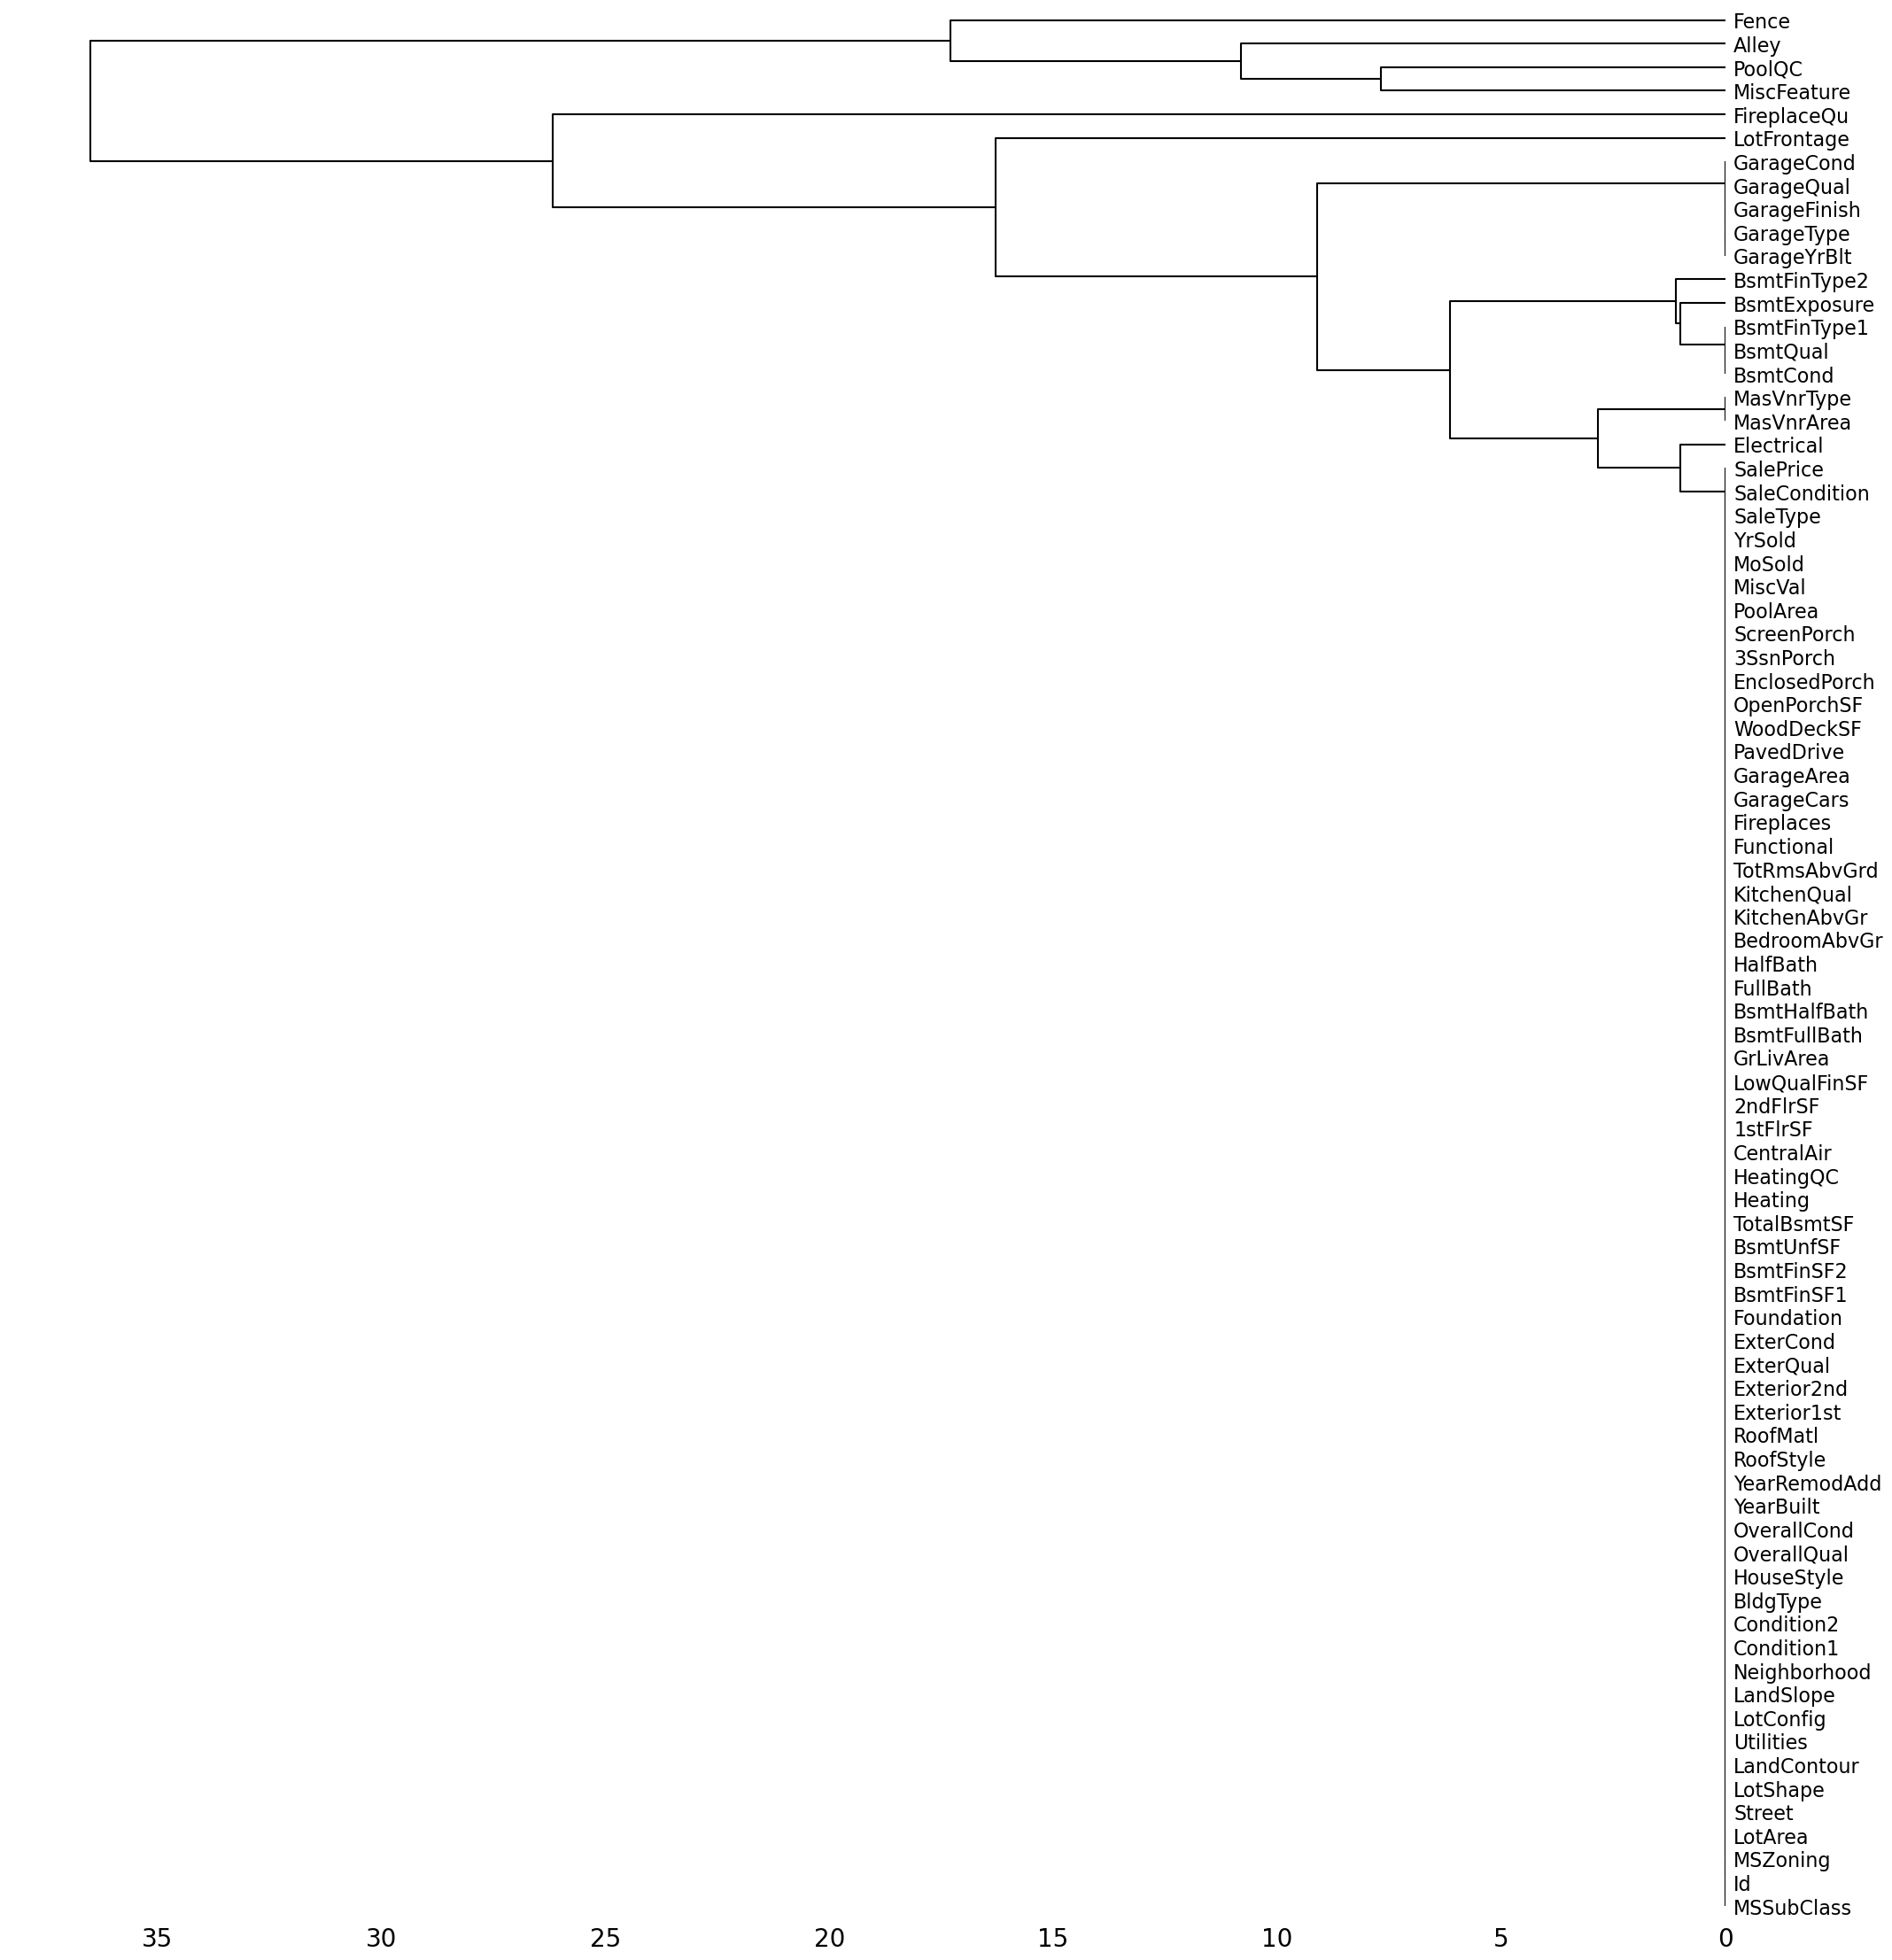

In [10]:
msno.dendrogram(housing_data)

## Data Cleaning and EDA

### From above analysis we are sure that we can delete these 4 columns; because PoolQC NA means no pool rather will delete pool area based on later analysis

In [11]:
housing_data=housing_data.drop(axis='columns',columns=['Fence','PoolArea','MiscFeature','Alley','FireplaceQu'], errors='ignore')

<Axes: >

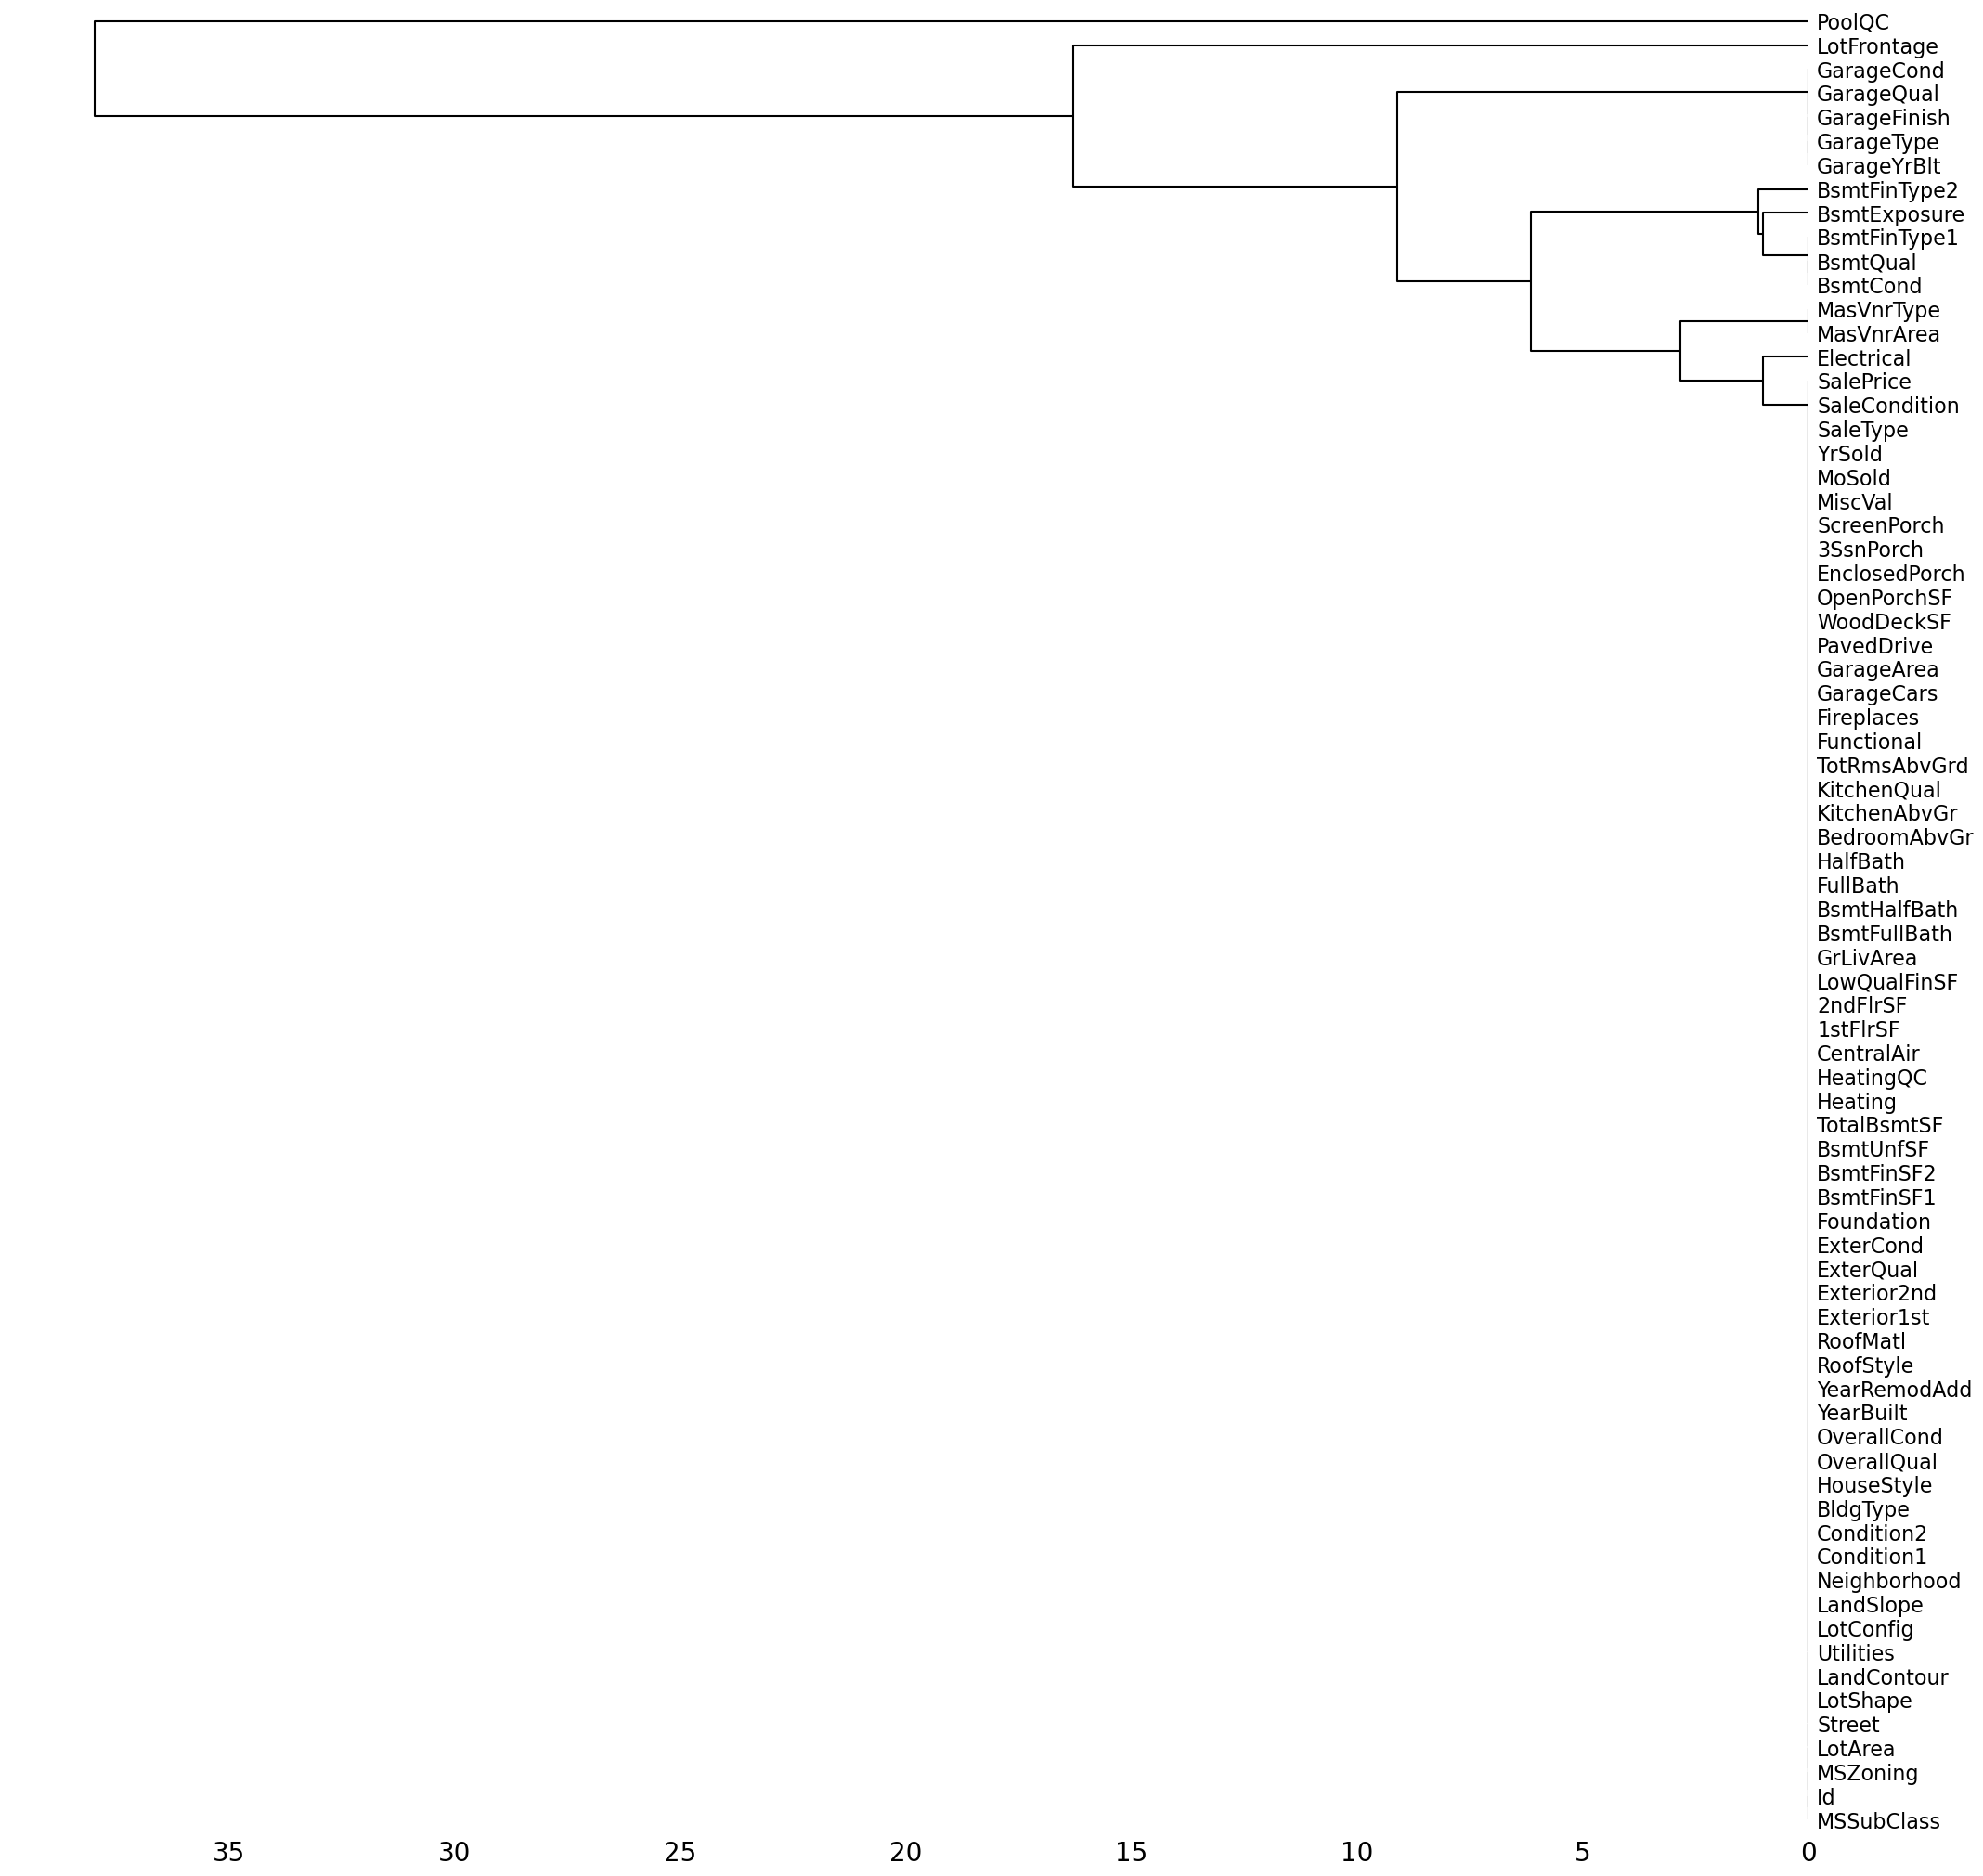

In [12]:
msno.dendrogram(housing_data)

### check for all the columns with unique values and find the ones with lot of unique values

In [13]:
housing_data_count=housing_data.nunique().sort_values(ascending=False).reset_index(name='count')
housing_data_count.head(10)

,index,count
0,Id,1460
1,LotArea,1073
2,GrLivArea,861
3,BsmtUnfSF,780
4,1stFlrSF,753
5,TotalBsmtSF,721
6,SalePrice,663
7,BsmtFinSF1,637
8,GarageArea,441
9,2ndFlrSF,417


In [14]:
housing_data[['Id','LotArea','GrLivArea','BsmtUnfSF','1stFlrSF','TotalBsmtSF','SalePrice','BsmtFinSF1','GarageArea','2ndFlrSF']].head(5)

,Id,LotArea,GrLivArea,BsmtUnfSF,1stFlrSF,TotalBsmtSF,SalePrice,BsmtFinSF1,GarageArea,2ndFlrSF
0,1,8450,1710,150,856,856,208500,706,548,854
1,2,9600,1262,284,1262,1262,181500,978,460,0
2,3,11250,1786,434,920,920,223500,486,608,866
3,4,9550,1717,540,961,756,140000,216,642,756
4,5,14260,2198,490,1145,1145,250000,655,836,1053


In [15]:
housing_data[['Id','LotArea','GrLivArea','BsmtUnfSF','1stFlrSF','TotalBsmtSF','SalePrice','BsmtFinSF1','GarageArea','2ndFlrSF']].describe()

,Id,LotArea,GrLivArea,BsmtUnfSF,1stFlrSF,TotalBsmtSF,SalePrice,BsmtFinSF1,GarageArea,2ndFlrSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,10516.828082,1515.463699,567.240411,1162.626712,1057.429452,180921.195890,443.639726,472.980137,346.992466
std,421.610009,9981.264932,525.480383,441.866955,386.587738,438.705324,79442.502883,456.098091,213.804841,436.528436
min,1.000000,1300.000000,334.000000,0.000000,334.000000,0.000000,34900.000000,0.000000,0.000000,0.000000
25%,365.750000,7553.500000,1129.500000,223.000000,882.000000,795.750000,129975.000000,0.000000,334.500000,0.000000
50%,730.500000,9478.500000,1464.000000,477.500000,1087.000000,991.500000,163000.000000,383.500000,480.000000,0.000000
75%,1095.250000,11601.500000,1776.750000,808.000000,1391.250000,1298.250000,214000.000000,712.250000,576.000000,728.000000
max,1460.000000,215245.000000,5642.000000,2336.000000,4692.000000,6110.000000,755000.000000,5644.000000,1418.000000,2065.000000


### From above analysis we know that ID needs to be dropped, & BsmtFinSF1 and 2ndFlrSF need to be analysed as in one 25% of data seems to be zero and for the other 50%.

In [16]:
housing_data['BsmtFinSF1'].value_counts()

0       467
24       12
16        9
686       5
662       5
       ... 
1338      1
1324      1
1460      1
328       1
830       1
Name: BsmtFinSF1, Length: 637, dtype: int64

In [17]:
# Let's also look at BsmtFinSF2 as it also might contain too many zeros.
housing_data['BsmtFinSF2'].value_counts()

0       1293
180        5
374        3
551        2
147        2
        ... 
532        1
165        1
1120       1
311        1
1029       1
Name: BsmtFinSF2, Length: 144, dtype: int64

In [18]:
housing_data['2ndFlrSF'].value_counts()

0       829
728      10
504       9
546       8
672       8
       ... 
1538      1
914       1
1067      1
1000      1
1152      1
Name: 2ndFlrSF, Length: 417, dtype: int64

In [19]:
housing_data['1stFlrSF'].value_counts()

864     25
1040    16
912     14
894     12
848     12
        ..
1509     1
2515     1
605      1
3138     1
1256     1
Name: 1stFlrSF, Length: 753, dtype: int64

In [20]:
housing_data[['1stFlrSF','2ndFlrSF']].value_counts()

1stFlrSF  2ndFlrSF
864       0           22
1040      0           14
894       0           11
848       0           11
816       0            9
                      ..
975       975          1
976       332          1
          732          1
          1111         1
4692      950          1
Length: 1118, dtype: int64

#### So from above analysis we know ID, BsmtFinSF1 and BsmtFinSF2 can be dropped as ID is a counter variable and gives no information, and BsmtFinSF1 and BsmtFinSF2 does tell us about the finished square feet number but most of there values are zero which means there is no basement and this same information is given to us but many other variables.

In [21]:
housing_data=housing_data.drop(axis='columns',columns=['BsmtFinSF1','BsmtFinSF2','Id'], errors='ignore')

In [22]:
housing_data_count.tail(10)

,index,count
66,LandContour,4
67,LandSlope,3
68,PoolQC,3
69,HalfBath,3
70,GarageFinish,3
71,BsmtHalfBath,3
72,PavedDrive,3
73,Street,2
74,CentralAir,2
75,Utilities,2


In [23]:
housing_data.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [24]:
housing_data.CentralAir.value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [25]:
housing_data.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [26]:
housing_data.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [27]:
housing_data['Street']=housing_data['Street'].astype('string')

In [28]:
temp=housing_data[['Street','PavedDrive']]
temp[temp.Street=='Grvl']

,Street,PavedDrive
52,Grvl,Y
335,Grvl,Y
582,Grvl,Y
812,Grvl,N
1061,Grvl,Y
1184,Grvl,Y


#### Though we get to know that street and paveddrive are not same after checking their values still as street has majority of the data covered by a single column we can remove it. Likewise we can also remove Utilities

In [29]:
housing_data=housing_data.drop(axis='columns',columns=['Street','Utilities'], errors='ignore')

In [30]:
housing_data.HalfBath.value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [31]:
housing_data.LandSlope.value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [32]:
housing_data.BsmtHalfBath.value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [33]:
housing_data.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [34]:
housing_data.FullBath.value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [35]:
housing_data.Fireplaces.value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [36]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  OverallCond    1460 non-null   int64  
 15  YearBuilt      1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

<Axes: >

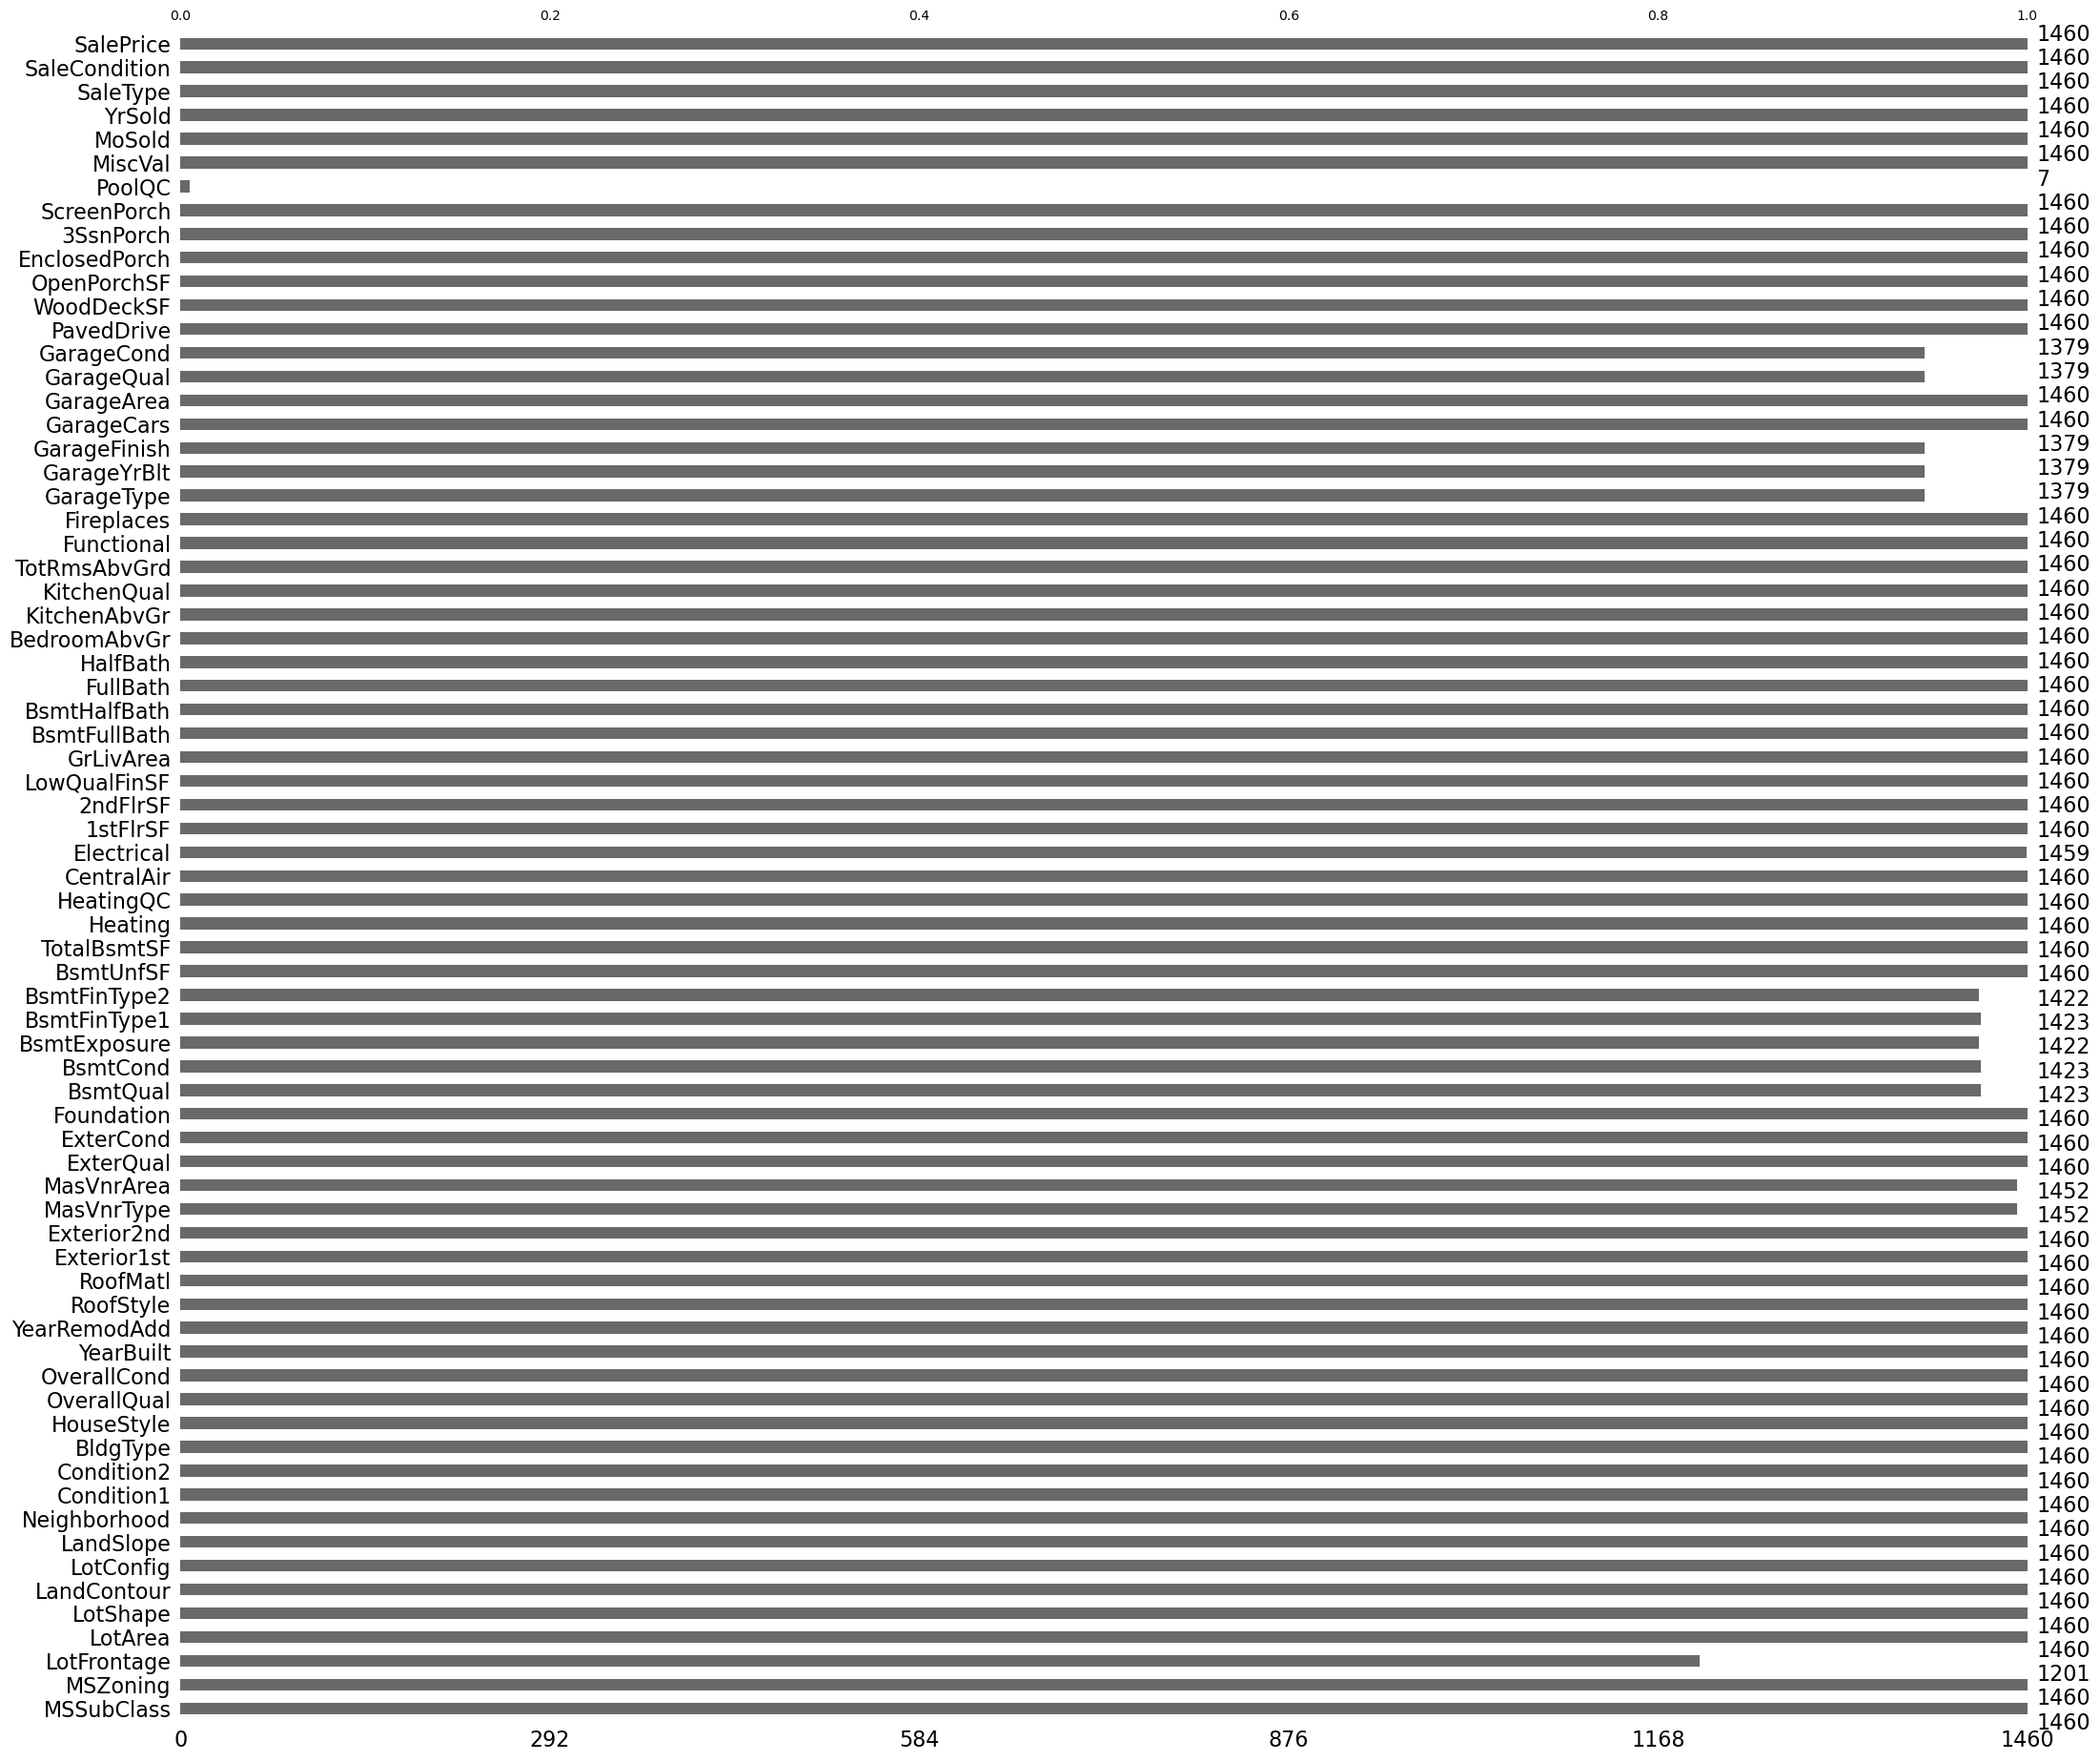

In [37]:
msno.bar(housing_data)

In [38]:
# Add 'NP' for na in poolQC as written in data dictionary
housing_data['PoolQC'].fillna('NP', inplace=True)

In [39]:
# remove rows having ~80% missing values
housing_data.dropna(axis = 1,thresh = 60, inplace=True)

In [40]:
temp = housing_data.isna().sum().sort_values(ascending=False)
temp.head(15)

LotFrontage     259
GarageYrBlt      81
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MasVnrArea        8
Electrical        1
KitchenAbvGr      0
dtype: int64

#### Now lets see where missing values need to be filled.

In [41]:
housing_data.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [42]:
housing_data.MasVnrArea.describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [43]:
housing_data[['MasVnrType','MasVnrArea']][(housing_data['MasVnrType'].isna()==True)]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [44]:
# As more than 50% of MasVnrArea is 0 we will be dropping this column.
housing_data=housing_data.drop(axis='columns',columns=['MasVnrArea'], errors='ignore')

In [45]:
housing_data.shape

(1460, 70)

In [46]:
housing_data.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [47]:
housing_data['MasVnrType'].mode()[0]

'None'

In [48]:
# fill missing values with mode for column MasVnrType
housing_data['MasVnrType'] = housing_data['MasVnrType'].fillna(housing_data['MasVnrType'].mode()[0])

In [49]:
housing_data.MasVnrType.value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [50]:
housing_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC',
       'MiscVal

In [51]:
housing_data.BsmtQual.value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [52]:
# in data dictionary its mentioned that na means no basement So we fillna with 'NB'
housing_data['BsmtQual'].fillna('NB', inplace=True)

In [53]:
housing_data.BsmtQual.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtQual
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [54]:
housing_data.BsmtCond.value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [55]:
housing_data['BsmtCond'].fillna('NB', inplace=True)

In [56]:
housing_data.BsmtFinType1.value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [57]:
housing_data['BsmtFinType1'].fillna('NB', inplace=True)

In [58]:
housing_data['BsmtFinType2'].fillna('NB', inplace=True)

In [59]:
housing_data['BsmtExposure'].fillna('NB', inplace=True)

In [60]:
housing_data.GarageCond.value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [61]:
housing_data['GarageCond'].fillna('NG', inplace=True)

In [62]:
housing_data['GarageQual'].fillna('NG', inplace=True)

In [63]:
housing_data['GarageFinish'].fillna('NG', inplace=True)

In [64]:
housing_data['GarageType'].fillna('NG', inplace=True)

In [65]:
temp = housing_data.isna().sum().sort_values(ascending=False)
temp.head(15)

LotFrontage     259
GarageYrBlt      81
Electrical        1
KitchenAbvGr      0
GarageType        0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
KitchenQual       0
BedroomAbvGr      0
GarageCars        0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
dtype: int64

In [66]:
#We can calculate the age of the Garage using GarageYrBlt
housing_data['GarageAge'] = housing_data.YrSold-housing_data.GarageYrBlt
housing_data.GarageAge

0        5.0
1       31.0
2        7.0
3        8.0
4        8.0
        ... 
1455     8.0
1456    32.0
1457    69.0
1458    60.0
1459    43.0
Name: GarageAge, Length: 1460, dtype: float64

In [67]:
housing_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC',
       'MiscVal

In [68]:
housing_data.GarageAge.isna().sum()

81

In [69]:
housing_data[['GarageCond','GarageYrBlt']][(housing_data['GarageYrBlt'].isna()==True)].nunique()

GarageCond     1
GarageYrBlt    0
dtype: int64

In [70]:
housing_data.GarageAge

0        5.0
1       31.0
2        7.0
3        8.0
4        8.0
        ... 
1455     8.0
1456    32.0
1457    69.0
1458    60.0
1459    43.0
Name: GarageAge, Length: 1460, dtype: float64

In [71]:
#now we can drop column GarageYrBlt
housing_data=housing_data.drop(axis='columns',columns=['GarageYrBlt'], errors='ignore')

In [72]:
housing_data[['GarageCond','GarageAge']][(housing_data['GarageAge'].isna()==True)]

,GarageCond,GarageAge
39,NG,NaN
48,NG,NaN
78,NG,NaN
88,NG,NaN
89,NG,NaN
...,...,...
1349,NG,NaN
1407,NG,NaN
1449,NG,NaN
1450,NG,NaN


In [73]:
# now we can fillna for GarageAge as 0 for the na values as these are the onces which don't have garage
housing_data['GarageAge'].fillna(0.0, inplace=True)

In [74]:
housing_data.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

### looking at LotFrontage values we see that mean and median are almost similar hence we can fairly assume there are no outliers here and we can use median value to fillna values.

In [75]:
housing_data['LotFrontage'].median()

69.0

In [76]:
housing_data['LotFrontage'].fillna(housing_data['LotFrontage'].median(), inplace=True)

In [77]:
temp = housing_data.isna().sum().sort_values(ascending=False)
temp.head(15)

Electrical      1
BedroomAbvGr    0
GarageType      0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
HalfBath        0
GarageCars      0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
dtype: int64

In [78]:
housing_data.shape

(1460, 70)

In [79]:
housing_data.dropna(axis = 0,how = 'any', inplace=True)

In [80]:
housing_data.shape

(1459, 70)

In [81]:
housing_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,GarageAge
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,56.881426,69.861549,10517.363948,6.100069,5.575737,1971.244003,1984.850583,567.366004,1057.891021,1162.906785,...,94.240576,46.692255,21.969157,3.411926,15.071282,43.518849,6.322824,2007.815627,180930.394791,27.698424
std,42.310746,22.035077,9984.666267,1.383171,1.113079,30.199555,20.644343,441.992392,438.500975,386.572089,...,125.381679,66.267472,61.137400,29.327247,55.775138,496.291826,2.704331,1.328542,79468.964025,24.948909
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000
25%,20.000000,60.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,223.000000,796.000000,882.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129950.000000,4.500000
50%,50.000000,69.000000,9477.000000,6.000000,5.000000,1973.000000,1994.000000,479.000000,992.000000,1088.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,24.000000
75%,70.000000,79.000000,11603.000000,7.000000,6.000000,2000.000000,2004.000000,808.000000,1298.500000,1391.500000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,46.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,2336.000000,6110.000000,4692.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,15500.000000,12.000000,2010.000000,755000.000000,107.000000


In [82]:
housing_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'MiscVal',
       'MoSold', 'Y

In [83]:
#Calculate Age of the house using YearBuilt column and years since it was remodelled
housing_data['HouseAge'] = housing_data.YrSold - housing_data.YearBuilt
housing_data['RemodelAge'] = housing_data.YrSold - housing_data.YearRemodAdd

In [84]:
# drop the YearBuilt and YearRemodAdd as they convey the same information as the new ones which are derived from them.
housing_data=housing_data.drop(axis='columns',columns=['YearBuilt','YearRemodAdd', 'YrSold'], errors='ignore')

In [85]:
housing_data.MiscVal.describe()

count     1459.000000
mean        43.518849
std        496.291826
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

In [86]:
# As we have already removed MiscFeature and Misc Val is also mostly 0 we can drop this also.
housing_data=housing_data.drop(axis='columns',columns=['MiscVal'], errors='ignore')

In [87]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   LotConfig      1459 non-null   object 
 7   LandSlope      1459 non-null   object 
 8   Neighborhood   1459 non-null   object 
 9   Condition1     1459 non-null   object 
 10  Condition2     1459 non-null   object 
 11  BldgType       1459 non-null   object 
 12  HouseStyle     1459 non-null   object 
 13  OverallQual    1459 non-null   int64  
 14  OverallCond    1459 non-null   int64  
 15  RoofStyle      1459 non-null   object 
 16  RoofMatl       1459 non-null   object 
 17  Exterior1st    1459 non-null   object 
 18  Exterior

In [88]:
housing_data.MoSold.value_counts()

6     253
7     234
5     203
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [89]:
## Convert four columns to 'object' type based on the data description provided
housing_data[['MSSubClass', 'OverallQual', 'OverallCond','MoSold']] = housing_data[['MSSubClass', 'OverallQual', 'OverallCond','MoSold']].astype('object')

In [90]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   object 
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   LotConfig      1459 non-null   object 
 7   LandSlope      1459 non-null   object 
 8   Neighborhood   1459 non-null   object 
 9   Condition1     1459 non-null   object 
 10  Condition2     1459 non-null   object 
 11  BldgType       1459 non-null   object 
 12  HouseStyle     1459 non-null   object 
 13  OverallQual    1459 non-null   object 
 14  OverallCond    1459 non-null   object 
 15  RoofStyle      1459 non-null   object 
 16  RoofMatl       1459 non-null   object 
 17  Exterior1st    1459 non-null   object 
 18  Exterior

## Univariate Analysis

<Axes: xlabel='SalePrice', ylabel='Density'>

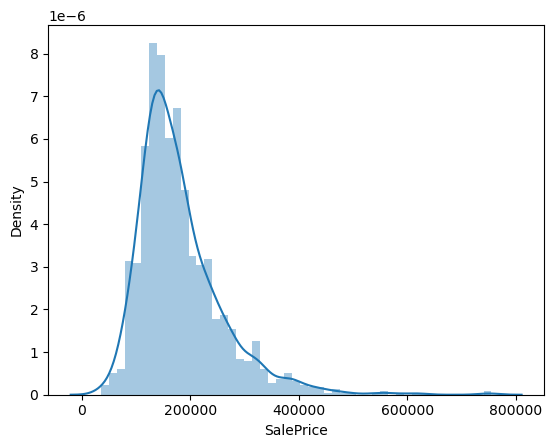

In [91]:
# Lets look at our target variable SalePrice
sns.distplot(housing_data['SalePrice'])


In [92]:
housing_data['SalePrice'].skew()

1.8819429948035529

<Axes: >

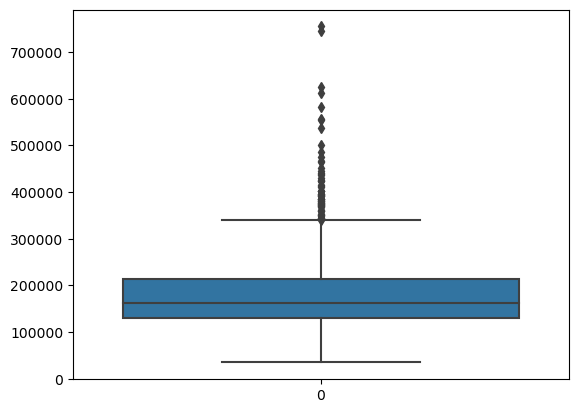

In [93]:
# Data is highly right skewed hence let's check for outliers
sns.boxplot(housing_data['SalePrice'])

In [94]:
housing_data.SalePrice.describe()

count      1459.000000
mean     180930.394791
std       79468.964025
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [95]:
# We saw that the values are too big and the distribution is also not normal hence we try to do log transformation.
housing_data.SalePrice = np.log(housing_data.SalePrice)

<Axes: xlabel='SalePrice', ylabel='Density'>

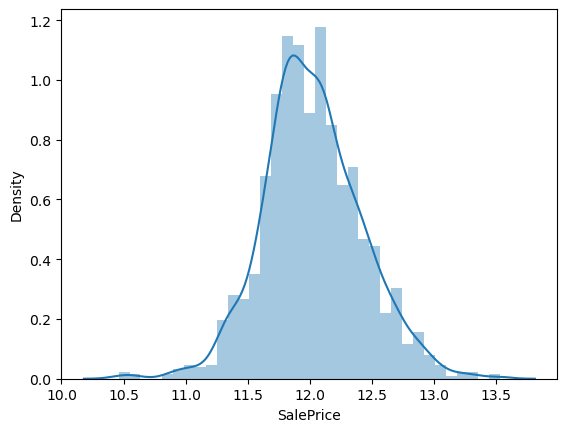

In [96]:
# Lets look at the distribution of salesprice after log transformation
sns.distplot(housing_data['SalePrice'])

In [97]:
housing_data['SalePrice'].skew()

0.12131775882415026

### Now our target variable looks normally distributed and it might help in getting better results using linear regression.

In [98]:
# Now list the columns which are numerical type
housing_data.select_dtypes(include=['int64', 'float64']).columns

Index(['LotFrontage', 'LotArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice', 'GarageAge',
       'HouseAge', 'RemodelAge'],
      dtype='object')

<Axes: >

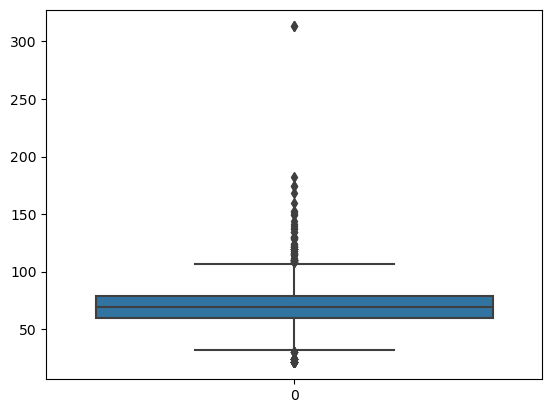

In [99]:
sns.boxplot(housing_data.LotFrontage)

In [100]:
housing_data.shape

(1459, 68)

In [101]:
# most of them seems to be above the upper-bound but lets not remove all these but only the one above 300
housing_data = housing_data[~(housing_data['LotFrontage']>300)]

In [102]:
housing_data.shape

(1457, 68)

<Axes: >

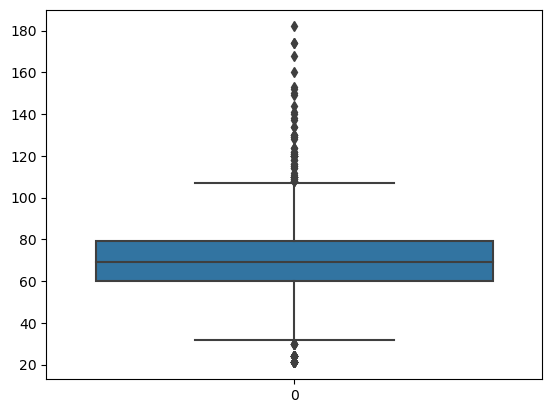

In [103]:
sns.boxplot(housing_data.LotFrontage)

<Axes: >

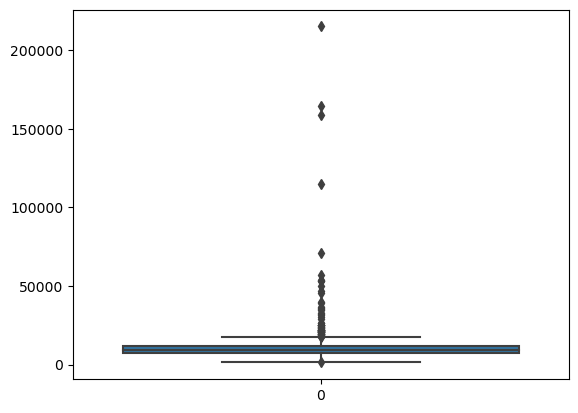

In [104]:
sns.boxplot(housing_data.LotArea)

In [105]:
# Calculate Inter Quantile Range
q1,q3 = housing_data['LotArea'].quantile([0.25,0.75])
iqr = q3-q1
print("Inter Quantile Range:",iqr)

Inter Quantile Range: 4060.0


In [106]:
# Check for upper and lower bound
lower_bound = q1-(1.5*iqr) 
upper_bound = q3+(1.5*iqr)
print("lower-bound",lower_bound)
print("upper-bound",upper_bound)

lower-bound 1450.0
upper-bound 17690.0


In [107]:
# most of them seems to be above the upper-bound but lets not remove all these but only the one above 150000
housing_data = housing_data[~(housing_data['LotArea']>150000)]

<Axes: >

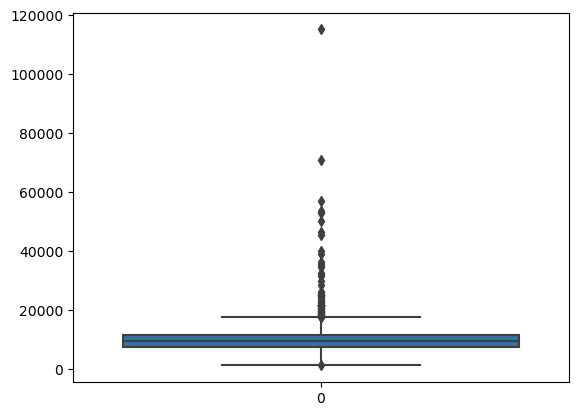

In [108]:
sns.boxplot(housing_data.LotArea)

<Axes: >

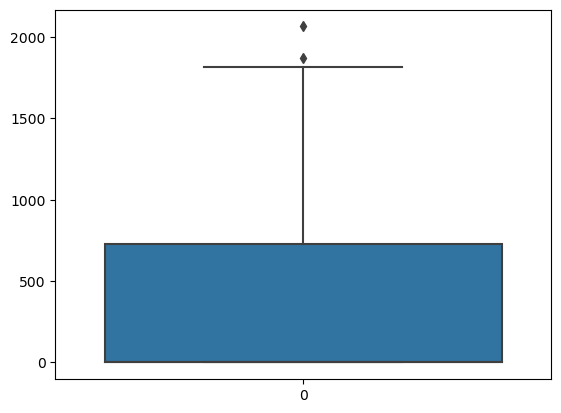

In [109]:
sns.boxplot(housing_data['2ndFlrSF'])

In [110]:
housing_data['2ndFlrSF'].value_counts()

0       827
728      10
504       9
672       8
546       8
       ... 
1015      1
1538      1
914       1
1067      1
1152      1
Name: 2ndFlrSF, Length: 414, dtype: int64

<Axes: >

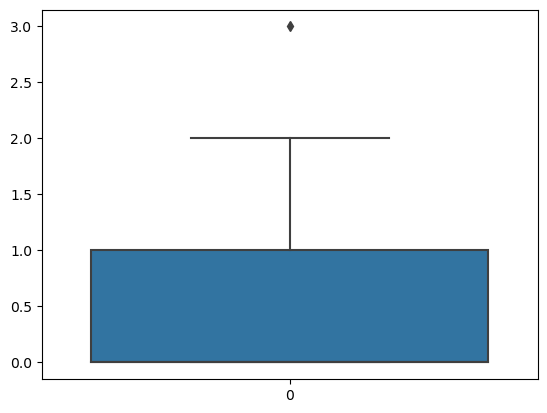

In [111]:
sns.boxplot(housing_data.BsmtFullBath)

In [112]:
housing_data['FullBath'].value_counts()

2    762
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [113]:
housing_data['HalfBath'].value_counts()

0    909
1    533
2     12
Name: HalfBath, dtype: int64

In [114]:
housing_data['BsmtFullBath'].value_counts()

0    854
1    587
2     12
3      1
Name: BsmtFullBath, dtype: int64

In [115]:
housing_data['BsmtHalfBath'].value_counts()

0    1373
1      79
2       2
Name: BsmtHalfBath, dtype: int64

In [116]:
housing_data['BedroomAbvGr'].value_counts()

3    800
2    358
4    211
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [117]:
housing_data['KitchenAbvGr'].value_counts()

1    1386
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [118]:
housing_data['Fireplaces'].value_counts()

0    689
1    649
2    112
3      4
Name: Fireplaces, dtype: int64

In [119]:
housing_data['GarageCars'].value_counts()

2    818
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

<Axes: >

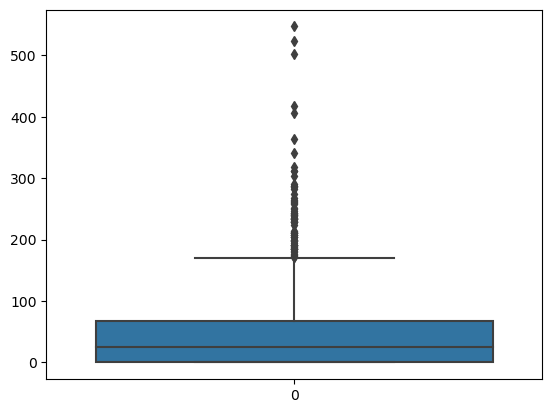

In [120]:
sns.boxplot(housing_data.OpenPorchSF)

<Axes: >

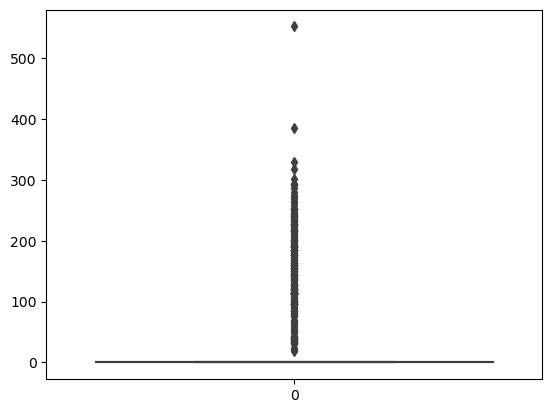

In [121]:
sns.boxplot(housing_data.EnclosedPorch)

<Axes: >

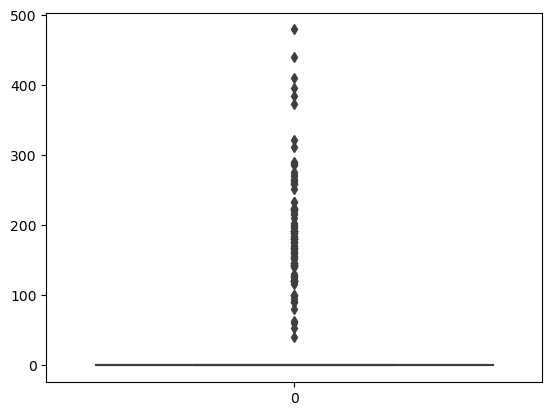

In [122]:
sns.boxplot(housing_data.ScreenPorch)

In [123]:
housing_data['PoolQC'].value_counts()

NP    1448
Ex       2
Fa       2
Gd       2
Name: PoolQC, dtype: int64

## We will leave few outliers as it is as they don't look because of some technical/data entry error 

In [124]:
# Now list the columns which are categorical type
housing_data.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

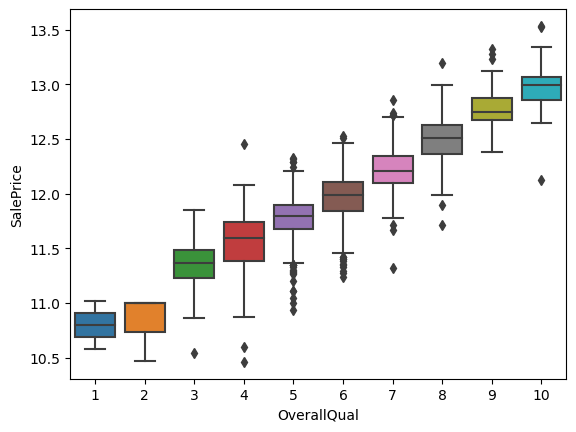

In [128]:
sns.boxplot(x='OverallQual',y='SalePrice',data=housing_data)

<Axes: xlabel='OverallCond', ylabel='SalePrice'>

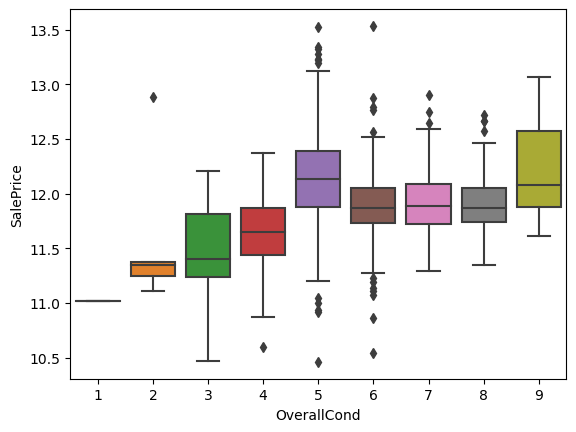

In [129]:
sns.boxplot(x='OverallCond',y='SalePrice',data=housing_data)

<Axes: xlabel='PoolQC', ylabel='SalePrice'>

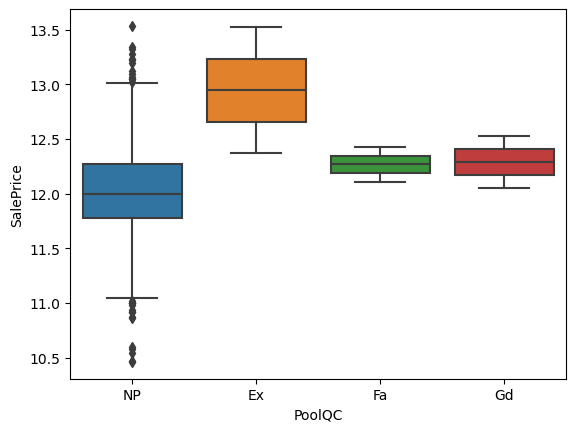

In [130]:
sns.boxplot(x='PoolQC',y='SalePrice',data=housing_data)

<Axes: xlabel='HeatingQC', ylabel='SalePrice'>

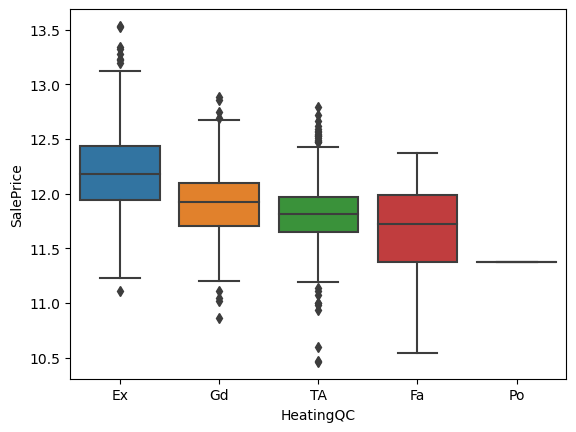

In [131]:
sns.boxplot(x='HeatingQC',y='SalePrice',data=housing_data)

<Axes: xlabel='CentralAir', ylabel='SalePrice'>

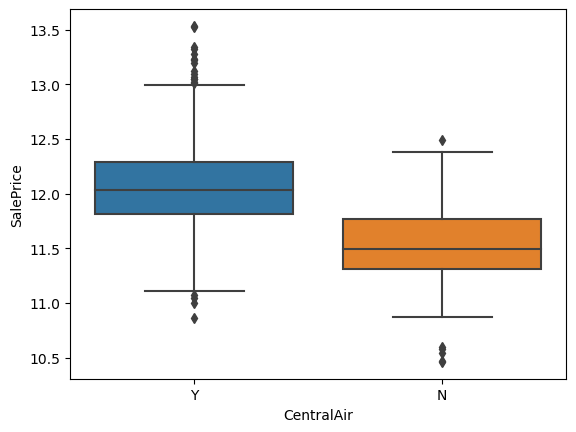

In [132]:
sns.boxplot(x='CentralAir',y='SalePrice',data=housing_data)

<Axes: xlabel='MoSold', ylabel='SalePrice'>

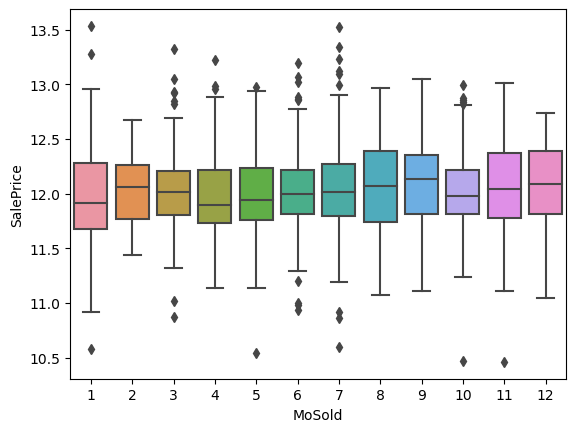

In [133]:
sns.boxplot(x='MoSold',y='SalePrice',data=housing_data)

<Axes: xlabel='GarageCond', ylabel='SalePrice'>

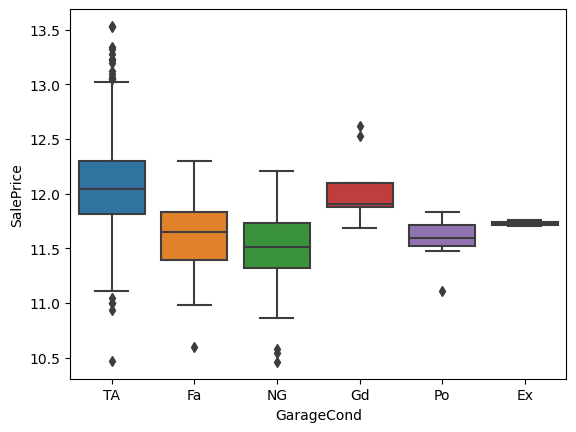

In [134]:
sns.boxplot(x='GarageCond',y='SalePrice',data=housing_data)

<Axes: xlabel='PavedDrive', ylabel='SalePrice'>

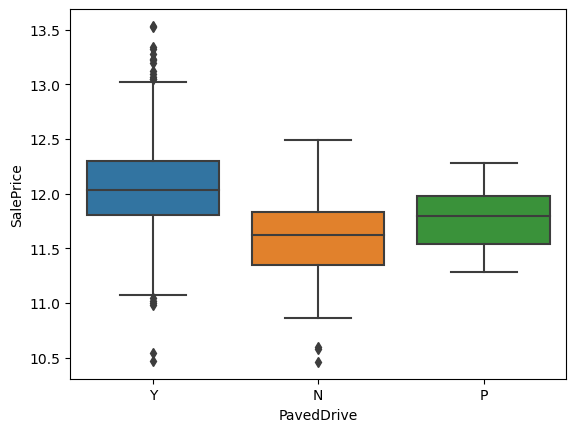

In [135]:
sns.boxplot(x='PavedDrive',y='SalePrice',data=housing_data)

### Observations:
1> As the overallqual increases the sales price also is seen increasing.<br>
2> The ones having centralAir were sold at higher prize.<br>
3> Good number of outliers are seen for the houses sold in june and july month.<br>
4> The houses having access to paved road at sold at better prices.

<Axes: xlabel='HouseAge', ylabel='SalePrice'>

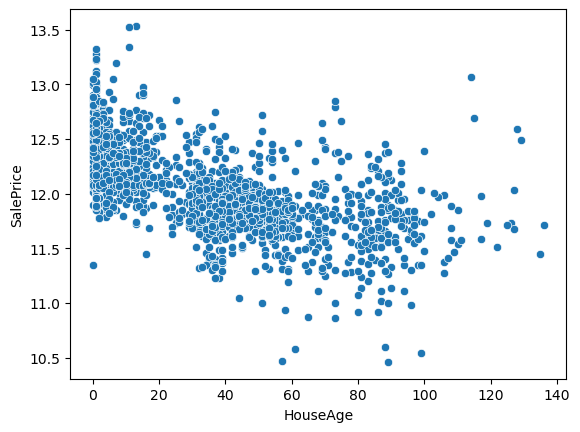

In [136]:
sns.scatterplot(x='HouseAge', y='SalePrice', data=housing_data)

<Axes: xlabel='RemodelAge', ylabel='SalePrice'>

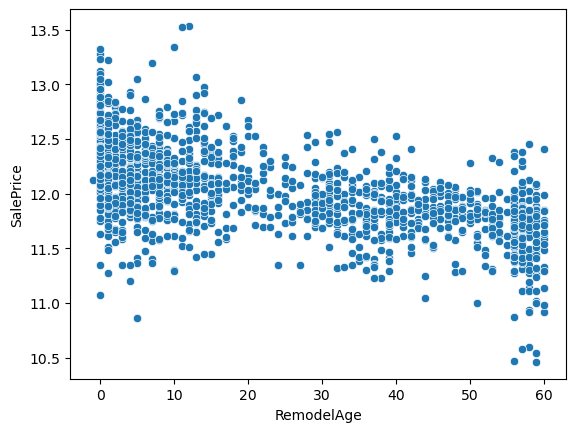

In [137]:
sns.scatterplot(x='RemodelAge', y='SalePrice', data=housing_data)

<Axes: xlabel='GarageAge', ylabel='SalePrice'>

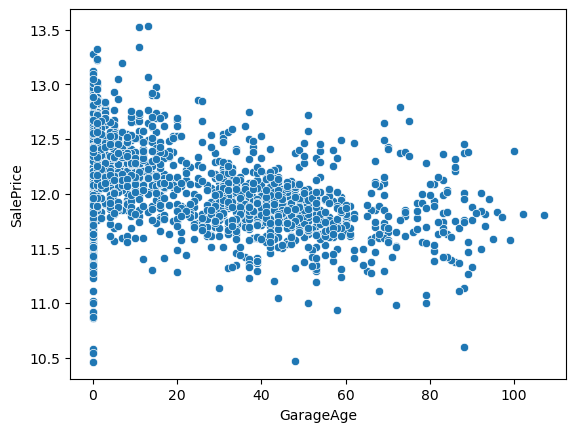

In [138]:
sns.scatterplot(x='GarageAge', y='SalePrice', data=housing_data)

### We can observe as the age of the asset is increasing the price of it is decreasing, which is obvious.

## Bivariate Analysis

<Axes: >

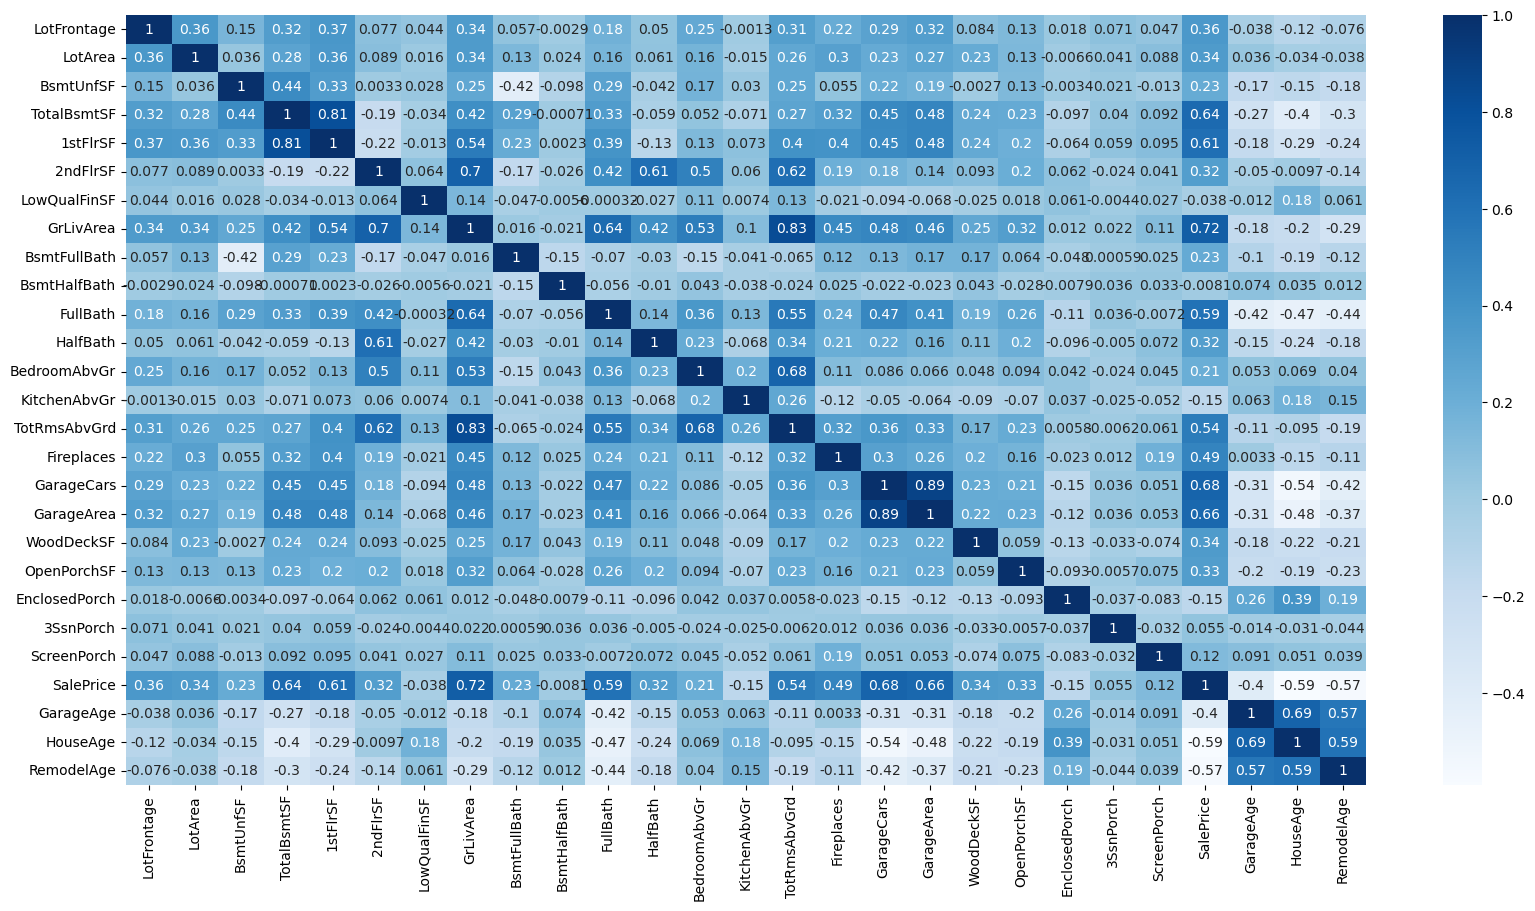

In [139]:
plt.figure(figsize=(20,10))
sns.heatmap(housing_data.corr(), annot = True, cmap='Blues')

### We observe some columns are still highly correlated with each other. We will use RFE to help eliminate those columns and remove multicollinearity.

In [142]:
len(housing_data.columns)

68

In [148]:
temp = housing_data.select_dtypes(include='object')
temp.head(10)

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,MoSold,SaleType,SaleCondition
0,60,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,2,WD,Normal
1,20,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,5,WD,Normal
2,60,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,9,WD,Normal
3,70,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,...,Typ,Detchd,Unf,TA,TA,Y,NP,2,WD,Abnorml
4,60,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,12,WD,Normal
5,50,RL,IR1,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,...,Typ,Attchd,Unf,TA,TA,Y,NP,10,WD,Normal
6,20,RL,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,8,WD,Normal
7,60,RL,IR1,Lvl,Corner,Gtl,NWAmes,PosN,Norm,1Fam,...,Typ,Attchd,RFn,TA,TA,Y,NP,11,WD,Normal
8,50,RM,Reg,Lvl,Inside,Gtl,OldTown,Artery,Norm,1Fam,...,Min1,Detchd,Unf,Fa,TA,Y,NP,4,WD,Abnorml
9,190,RL,Reg,Lvl,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,...,Typ,Attchd,RFn,Gd,TA,Y,NP,1,WD,Normal


In [147]:
temp[['HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual']].head(10)

,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,...,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual
0,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd
1,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,...,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA
2,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd
3,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,...,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd
4,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd
5,1.5Fin,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,...,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA
6,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,Gd,TA,...,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd
7,2Story,7,6,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,...,Gd,TA,Mn,ALQ,BLQ,GasA,Ex,Y,SBrkr,TA
8,1.5Fin,7,5,Gable,CompShg,BrkFace,Wd Shng,None,TA,TA,...,TA,TA,No,Unf,Unf,GasA,Gd,Y,FuseF,TA
9,1.5Unf,5,6,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,...,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA


In [145]:
housing_data.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

#### Get Dummy variables for categorical columns

In [149]:
housing_data = pd.get_dummies(data=housing_data,columns=['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'MoSold', 'SaleType',
       'SaleCondition'],drop_first=True)

In [150]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1459
Columns: 274 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(24), uint8(247)
memory usage: 701.1 KB


In [152]:
housing_data.shape

(1454, 274)

## Model Building
### Spliting into train and test

In [155]:
df_train, df_test = train_test_split(housing_data, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(1017, 274)
(437, 274)


### Scale the numerical variables

In [156]:
# Instantiate an object
scaler = MinMaxScaler()

# Create a list of numeric variables
nv = ['LotFrontage', 'LotArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice', 'GarageAge',
       'HouseAge', 'RemodelAge']

# fit and transform only training set
df_train[nv] = scaler.fit_transform(df_train[nv])

In [157]:
df_train.head()

,LotFrontage,LotArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1306,0.167702,0.081413,0.585616,0.442146,0.403276,0.0,0.0,0.249638,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,1
368,0.354037,0.093578,0.311644,0.409825,0.364275,0.0,0.0,0.225495,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
309,0.428571,0.159485,0.266267,0.612799,0.627925,0.0,0.0,0.388701,0.333333,0.0,...,0,0,0,0,1,0,0,0,1,0
659,0.335404,0.124343,0.363442,0.480284,0.449298,0.0,0.0,0.278127,0.333333,0.0,...,0,0,0,0,1,0,0,0,1,0
726,0.298137,0.293618,0.030822,0.284421,0.524961,0.0,0.0,0.324964,0.333333,0.0,...,0,0,0,0,1,0,0,0,1,0


## Training the Model
### Dividing into X and y sets for model building

In [158]:
y_train = df_train.pop('SalePrice')
X_train = df_train

### Use RFE (Recursive Feature Elimination)

In [159]:
# Running RFE with output number of variable equal to 40
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=40)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=40)

In [160]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 69),
 ('LotArea', True, 1),
 ('BsmtUnfSF', False, 15),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 68),
 ('BsmtHalfBath', False, 179),
 ('FullBath', False, 126),
 ('HalfBath', False, 127),
 ('BedroomAbvGr', False, 232),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 125),
 ('Fireplaces', False, 109),
 ('GarageCars', True, 1),
 ('GarageArea', False, 66),
 ('WoodDeckSF', False, 80),
 ('OpenPorchSF', False, 81),
 ('EnclosedPorch', False, 64),
 ('3SsnPorch', False, 65),
 ('ScreenPorch', False, 51),
 ('GarageAge', False, 157),
 ('HouseAge', True, 1),
 ('RemodelAge', False, 70),
 ('MSSubClass_30', False, 67),
 ('MSSubClass_40', False, 47),
 ('MSSubClass_45', False, 26),
 ('MSSubClass_50', False, 166),
 ('MSSubClass_60', False, 168),
 ('MSSubClass_70', False, 134),
 ('MSSubClass_75', False, 58),
 ('MSSubClass_80', False, 186),
 ('MSSubClass_85', False, 217

In [161]:
column = X_train.columns[rfe.support_]
column

Index(['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'KitchenAbvGr', 'GarageCars', 'HouseAge', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9',
       'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior2nd_CBlock',
       'BsmtCond_NB', 'BsmtCond_Po', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall', 'Electrical_Mix', 'Functional_Sev', 'GarageType_NG',
       'GarageFinish_NG', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_NG',
       'GarageCond_Po', 'GarageCond_TA', 'PoolQC_Gd'],
      dtype='object')

In [162]:
X_train.columns[~rfe.support_]

Index(['LotFrontage', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=233)

In [163]:
# Creating X_train_rfe dataframe using the 40 columns selected by RFE
X = X_train[column]

In [173]:
X_train=X

In [170]:
y_train

### Ridge Regression

In [174]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [175]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1.0}


In [176]:
#Fitting Ridge model for alpha = 1 and printing coefficients which have been penalised
alpha = 1.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.09897511  0.24697928  0.18103999  0.15754246 -0.0160909   0.18861443
 -0.12017857  0.1088901  -0.15808015  0.09307834  0.06420989  0.07396423
  0.05136732 -0.08223995 -0.04834715  0.02932343  0.04416807  0.0690255
 -0.06358664 -0.01142979 -0.01142979  0.00728843 -0.04479233 -0.02193095
 -0.01741905  0.03253554 -0.04479233 -0.10054391 -0.00466469 -0.00466469
 -0.01356866  0.02729191 -0.0277222  -0.00892813 -0.00985716 -0.0230974
 -0.00466469  0.01230636 -0.00227888  0.02329383]


In [178]:
df_test.head()

,LotFrontage,LotArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
530,85.0,10200,678,1461,1509,0,0,1509,1,0,...,0,0,0,0,1,0,0,0,0,0
434,21.0,1890,135,630,630,0,0,630,1,0,...,0,0,0,0,1,0,0,0,1,0
1030,69.0,7082,686,686,948,980,0,1928,0,0,...,0,0,0,0,1,0,0,0,1,0
672,69.0,11250,441,1208,1208,0,0,1208,1,0,...,0,0,0,0,1,0,0,0,1,0
1185,60.0,9738,392,784,949,272,0,1221,1,0,...,0,0,0,0,1,0,0,0,1,0


In [180]:
df_test[nv]= scaler.transform(df_test[nv])

In [181]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [183]:
X_test = X_test[column]

In [184]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8865390820477099
0.7992596982052663
1.9421870660676102
1.5650011150132157
0.0019097217955433728
0.0035812382494581595


## Lasso Regression

In [185]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [186]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [187]:
#Fitting lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [188]:
lasso.coef_

array([ 9.34360584e-02,  2.66660006e-01,  2.17158090e-01,  1.95008105e-01,
       -0.00000000e+00,  1.23557085e-01, -1.16620556e-01,  1.02163528e-01,
       -1.61316799e-01,  7.30995813e-02,  4.10057350e-02,  5.45106399e-02,
        3.16991402e-02, -8.35993459e-02, -4.74976817e-02,  2.98110919e-02,
        4.44626105e-02,  6.92145670e-02, -4.25227606e-02, -0.00000000e+00,
       -0.00000000e+00,  1.24421491e-02, -2.86511602e-02, -0.00000000e+00,
       -0.00000000e+00,  1.66155965e-02, -4.45414236e-05, -9.84215466e-02,
        0.00000000e+00,  0.00000000e+00, -1.33089199e-04,  2.79218505e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.38598696e-03,  0.00000000e+00])

In [189]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8843456522060802
0.7938345511015564
1.979733484214266
1.6072963650975685
0.0019466405941143225
0.0036780237187587377


In [192]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.886539,0.884346
1,R2 Score (Test),0.799260,0.793835
2,RSS (Train),1.942187,1.979733
3,RSS (Test),1.565001,1.607296
4,MSE (Train),0.043700,0.044121
5,MSE (Test),0.059843,0.060647


## Lets observe the changes in the coefficients after regularization

In [193]:
betas = pd.DataFrame(index=X.columns)

In [194]:
betas.rows = X.columns

In [195]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [199]:
pd.set_option('display.max_rows', None)
betas.head(40)

,Ridge,Lasso
LotArea,0.098975,0.093436
TotalBsmtSF,0.246979,0.266660
1stFlrSF,0.181040,0.217158
2ndFlrSF,0.157542,0.195008
LowQualFinSF,-0.016091,-0.000000
GrLivArea,0.188614,0.123557
KitchenAbvGr,-0.120179,-0.116621
GarageCars,0.108890,0.102164
HouseAge,-0.158080,-0.161317
MSZoning_FV,0.093078,0.073100


## Inferences from both the models
1> If Total basement area is more then the price of property also increases.<br>
2> Square Feet area of 1st and 2nd floor is also directly helps in appreciating the value of the property.<br>
3> If House age is more its value is less. Hence try to aquire houses which are not too old.<br>
4> We see that over all condition of the house when less like 3,4 then it was evaluvated at less price but when its 7,8 or 9 its having a good positive effect on the sales price.<br>
5> We see functional is not having that effect on the price until its Severely Damaged. But if that's the case it having a negative effect on the price evaluation.<br>
6> Garage Cars and GrLivArea didn't had major impact but slight positive effect so can say its a good to have things.


# PDF Questions

## If i had chosen double the value of alpha for ridge

In [200]:
#Fitting Ridge model for alpha = 2.0 and printing coefficients which have been penalised
alpha = 2.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.09082106  0.2237333   0.1839003   0.15162477 -0.01510582  0.18755701
 -0.10598457  0.11327774 -0.15703187  0.07511369  0.04329366  0.05823038
  0.03331243 -0.08021977 -0.04881926  0.0284646   0.04282633  0.06392462
 -0.04775587 -0.00893657 -0.00893657 -0.00301183 -0.03209135 -0.01861154
 -0.01087594  0.02388871 -0.03209135 -0.0665778  -0.00290189 -0.00290189
 -0.01083794  0.02646525 -0.02156674 -0.00713028 -0.00779993 -0.01482558
 -0.00290189  0.00705442  0.00250137  0.01488802]


In [201]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8833505618206232
0.8000349744967007
1.9967671175664612
1.5589569462554205
0.0019633894961322137
0.0035674071996691543


In [202]:
#Fitting Lasso model for alpha = 0.0002 and printing coefficients which have been penalised

alpha =0.0002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [203]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8775884783622901
0.7920513494421874
2.0954005868557046
1.6211984692602877
0.0020603742250301913
0.003709836314096768


After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [204]:
X_train=X_train.drop(axis='columns',columns=['TotalBsmtSF','1stFlrSF','2ndFlrSF','HouseAge','OverallCond_9'], errors='ignore')

In [205]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [206]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [207]:
#Fitting lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [209]:
betas = pd.DataFrame(index=X_train.columns)

In [214]:
betas.rows = X.columns
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)
betas.head(40)

,Lasso
LotArea,7.690946e-02
LowQualFinSF,-8.196652e-02
GrLivArea,5.533361e-01
KitchenAbvGr,-1.420428e-01
GarageCars,2.486390e-01
MSZoning_FV,1.463683e-01
MSZoning_RH,6.895667e-02
MSZoning_RL,1.244246e-01
MSZoning_RM,6.648310e-02
OverallCond_3,-9.634429e-02
